In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder \
    .appName("HousePricePrediction_LR") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "100") \
    .getOrCreate()

In [2]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'files'
train_path = str(DATA_DIR / "train.csv")
test_path  = str(DATA_DIR/"test.csv")

train_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")   # 关键：自动推断数值类型
            .option("nullValue", "NA")       # 可选：明确 NA 为 null
            .csv(train_path))

test_df = (spark.read
           .option("header", "true")
           .option("inferSchema", "true")
           .option("nullValue", "NA")
           .csv(test_path))

print("=== Train Schema ===")
train_df.printSchema()
print(f"Train rows: {train_df.count()}, cols: {len(train_df.columns)}")

print("\n=== Test Schema ===")
test_df.printSchema()

=== Train Schema ===
root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string 

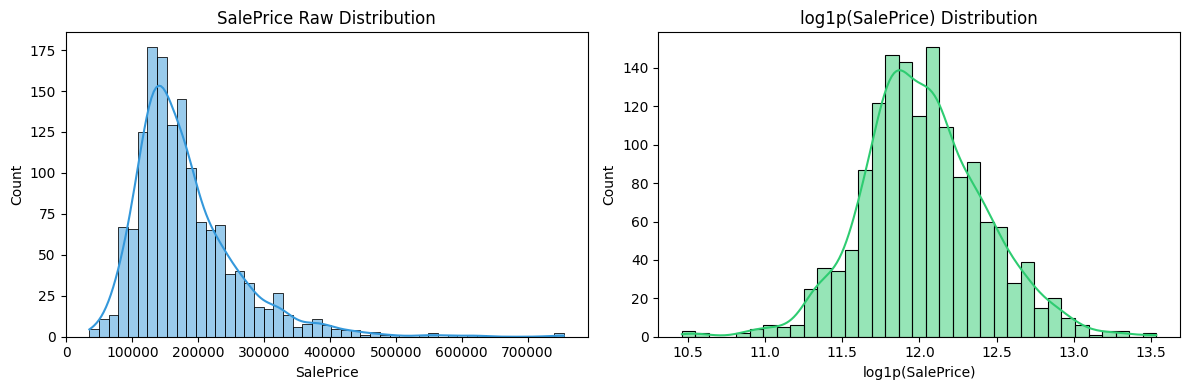

In [3]:
# ============== 1 目标变量分布 + log变换前后对比 ==============

# 转 pandas 只取 SalePrice 列（速度快）
price = train_df.select("SalePrice").toPandas()["SalePrice"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(price, kde=True, ax=axs[0], color="#3498db")
axs[0].set_title("SalePrice Raw Distribution")
axs[0].set_xlabel("SalePrice")

sns.histplot(np.log1p(price), kde=True, ax=axs[1], color="#2ecc71")
axs[1].set_title("log1p(SalePrice) Distribution")
axs[1].set_xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()

In [4]:
# === 区分列类型（基于实际 schema）===

from pyspark.sql.types import IntegerType, DoubleType, StringType

num_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, (IntegerType, DoubleType))
            and field.name != "SalePrice"]

cat_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, StringType)]

print(f"数值列 ({len(num_cols)}): {num_cols[:10]}...")
print(f"类别列 ({len(cat_cols)}): {cat_cols[:10]}...")

数值列 (37): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']...
类别列 (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...


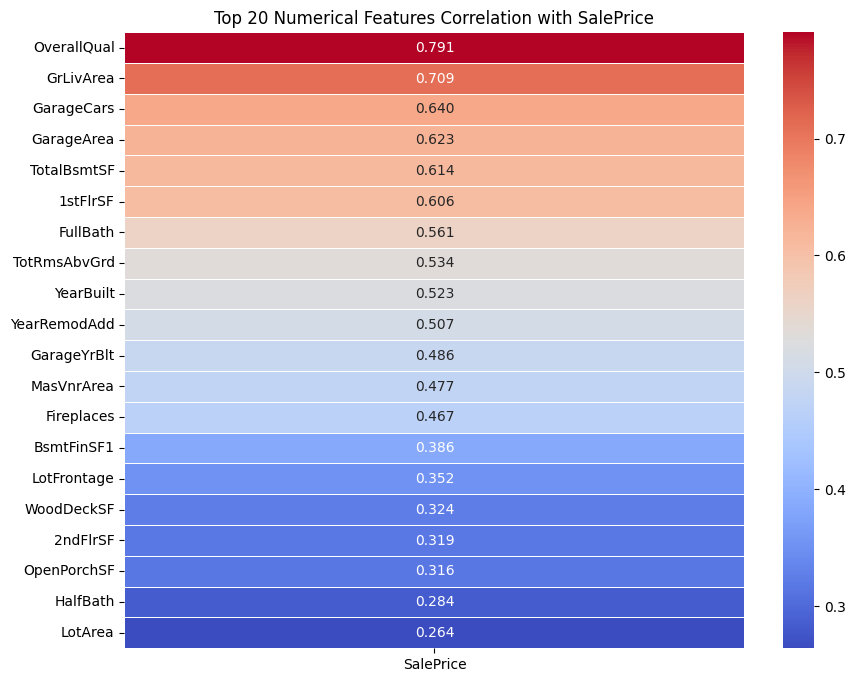

In [5]:
# ============== 2 数值特征相关性热力图（Top 20） ==============
# 数值列 + SalePrice
num_with_price = num_cols + ["SalePrice"]
corr_df = train_df.select(num_with_price).toPandas().corr()

# 取与 SalePrice 最相关的 20 个特征
top_corr = corr_df["SalePrice"].abs().sort_values(ascending=False)[1:21]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.loc[top_corr.index, ["SalePrice"]], 
            annot=True, cmap="coolwarm", fmt=".3f", linewidths=.5)
plt.title("Top 20 Numerical Features Correlation with SalePrice")
plt.show()

In [6]:
from pyspark.sql import functions as F
# === 数值列：中位数填补 ===
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy="median")

# 分别 fit，避免 train/test 统计泄露
train_df = imputer.fit(train_df).transform(train_df)
test_df  = imputer.fit(test_df).transform(test_df)

# === 类别列：缺失值填 "Missing" ===
for c in cat_cols:
    train_df = train_df.fillna({c: "Missing"})
    test_df  = test_df.fillna({c: "Missing"})

# 验证无缺失
print("数值列缺失统计:")
train_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in num_cols]).show()

数值列缺失统计:
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+-----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageYrBlt|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+---

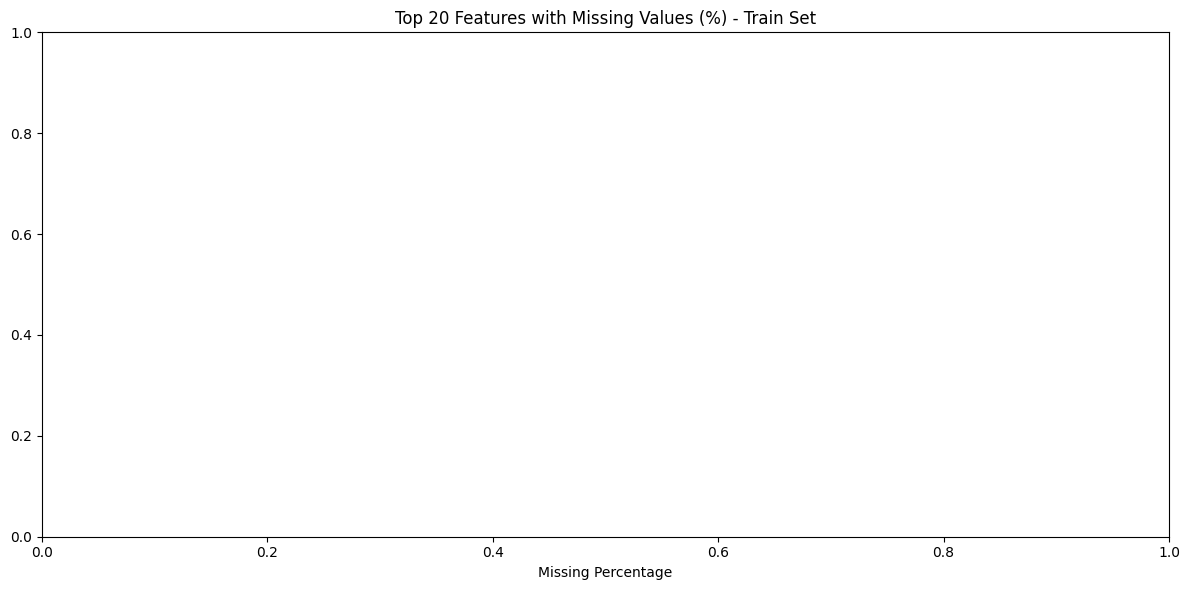

In [8]:
# ============== 3 缺失值热力图（修复版）==============
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每列缺失数量
miss_counts = train_df.select([
    (F.count(F.when(F.col(c).isNull() | (F.col(c) == "NA"), c))).alias(c)
    for c in train_df.columns
]).toPandas()

# 转置 + 计算百分比
miss_pct = miss_counts.iloc[0] / train_df.count()  # 直接得到 Series，index 是列名
miss_pct = miss_pct[miss_pct > 0].sort_values(ascending=False)  # 只保留有缺失的

plt.figure(figsize=(12, 6))
sns.barplot(x=miss_pct.values[:20], y=miss_pct.index[:20], palette="Reds_r")
plt.title("Top 20 Features with Missing Values (%) - Train Set")
plt.xlabel("Missing Percentage")
plt.ylabel("")
for i, v in enumerate(miss_pct.values[:20]):
    plt.text(v + 0.001, i, f"{v:.1%}", va="center")
plt.tight_layout()
plt.show()

In [9]:
# === 类别编码：StringIndexer + OneHotEncoder ===
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in cat_cols
]

encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec", handleInvalid="keep")
    for c in cat_cols
]

# 数值特征标准化
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler_num = VectorAssembler(inputCols=num_cols, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num", withStd=True, withMean=True)

# 最终特征向量
feature_cols = [c + "_vec" for c in cat_cols] + ["scaled_num"]
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 目标：对 SalePrice 取 log
import pyspark.sql.functions as F
train_df = train_df.withColumn("logSalePrice", F.log1p(F.col("SalePrice")))
target_col = "logSalePrice"

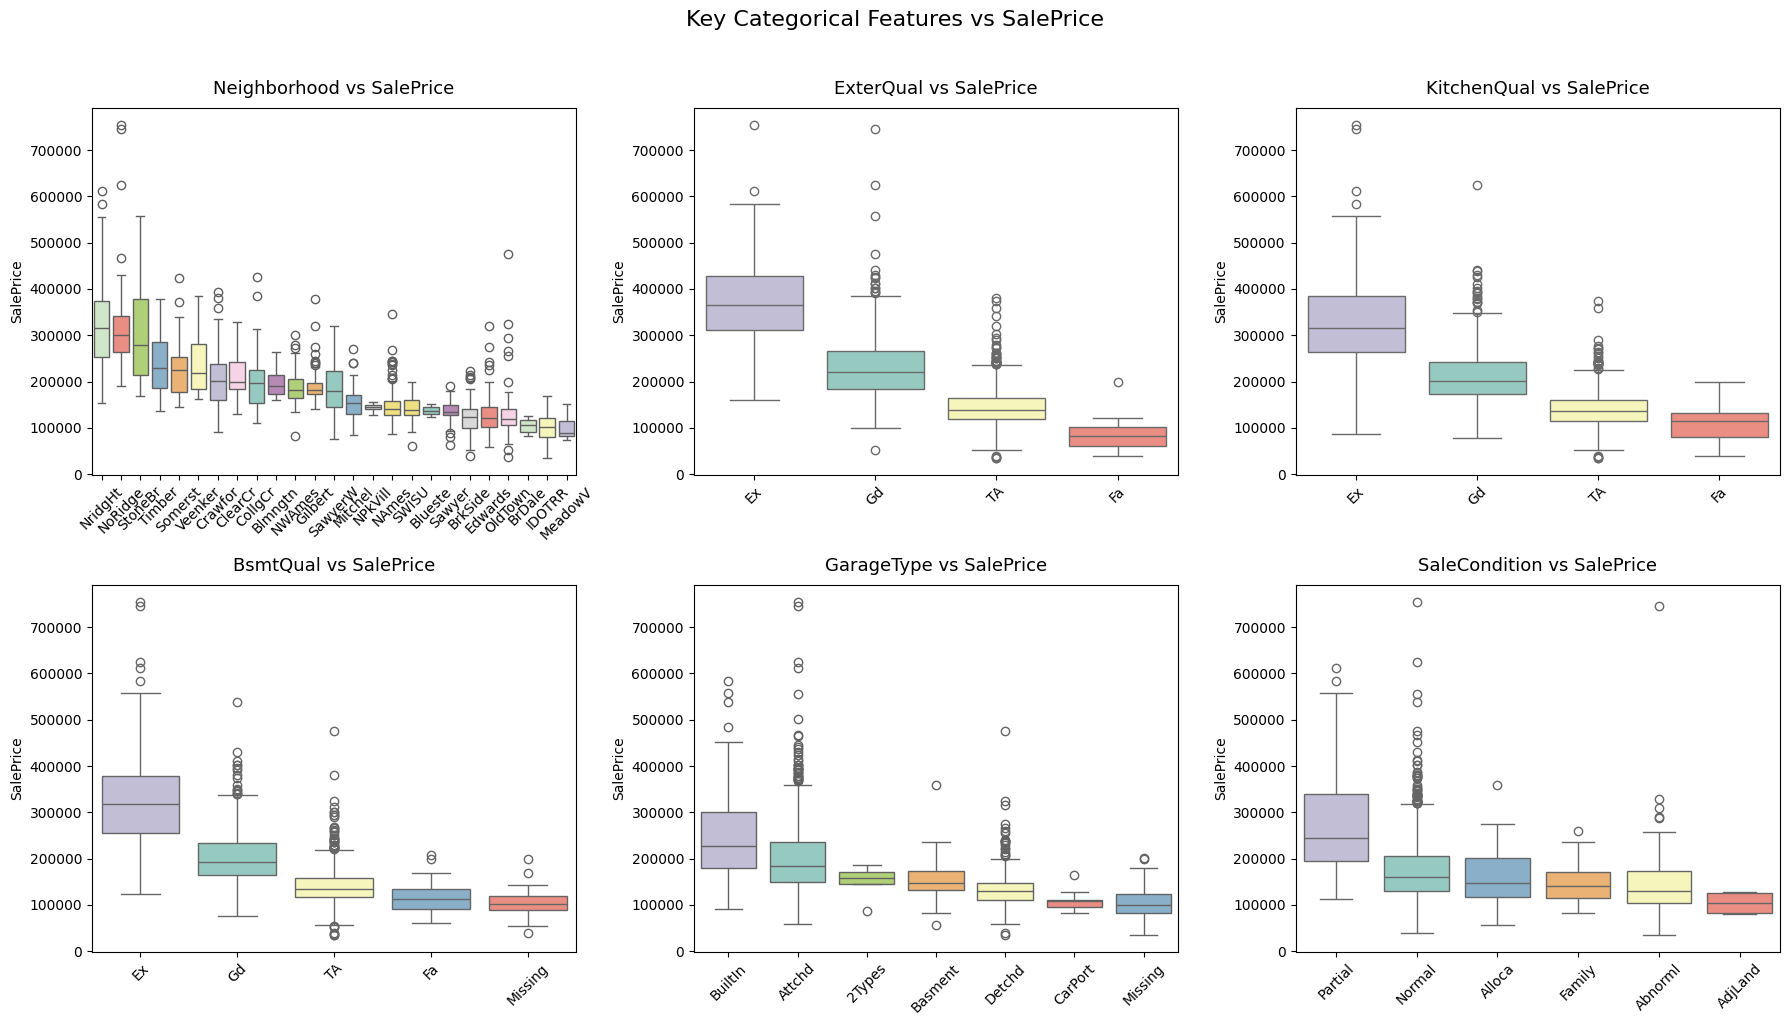

In [11]:
# ============== 4 重要类别特征箱线图（已消除所有警告）==============
top_cat = ["Neighborhood", "ExterQual", "KitchenQual", "BsmtQual", "GarageType", "SaleCondition"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(top_cat):
    data = train_df.select(col, "SalePrice").toPandas()
    # 按中位数排序，让箱线图更有意义
    order = data.groupby(col)["SalePrice"].median().sort_values(ascending=False).index
    
    sns.boxplot(x=col, y="SalePrice", data=data, order=order, ax=axes[i],
                hue=col, palette="Set3", legend=False)   # 关键修改在这行
    
    axes[i].set_title(f"{col} vs SalePrice", fontsize=13, pad=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel("")

plt.suptitle("Key Categorical Features vs SalePrice", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [12]:
# === 1. 导入 LinearRegression ===
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol=target_col,
    regParam=0.01,      # 弹性网正则强度，可调
    elasticNetParam=0.0,  # =0 为纯 Ridge；=1 为纯 Lasso
    maxIter=100,
    tol=1e-6,
    standardization=True  # 已在 pipeline 里做过标准化，可 True 或 False
)

# === 2. 组装 Pipeline ===
pipeline_lr = Pipeline(stages=indexers + encoders +
                       [assembler_num, scaler, final_assembler, lr])

In [13]:
train_set, val_set = train_df.randomSplit([0.8, 0.2], seed=42)

# === 4. 训练与评估（把原来的 pipeline_rf 换成 pipeline_lr） ===
model_lr = pipeline_lr.fit(train_set)
pred_lr = model_lr.transform(val_set)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
rmse_lr = evaluator.evaluate(pred_lr)
r2_lr = RegressionEvaluator(labelCol=target_col, metricName="r2").evaluate(pred_lr)
print(f"LR RMSE (log): {rmse_lr:.4f}, R²: {r2_lr:.4f}")

LR RMSE (log): 0.1255, R²: 0.8956


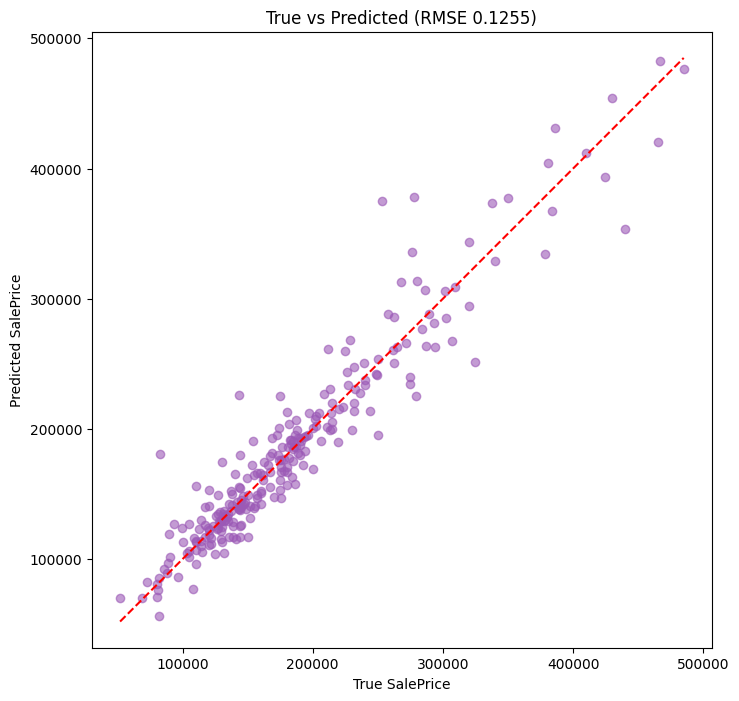

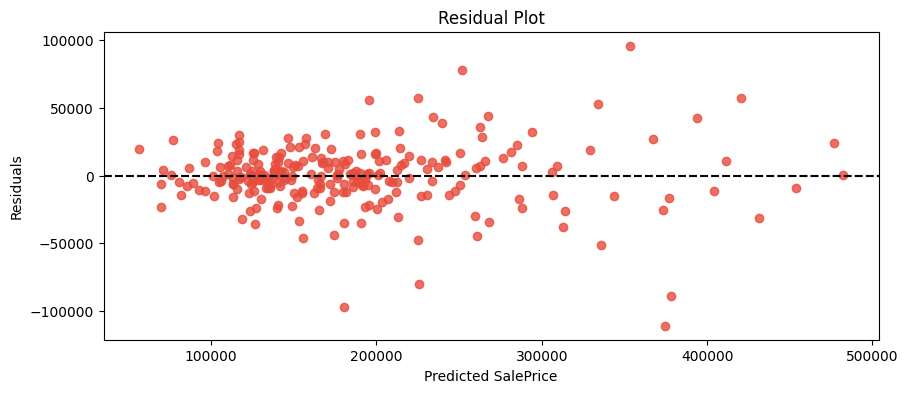

In [15]:
# ============== 5 真实值 vs 预测值散点图（验证集） ==============
pred_pd = pred_lr.select("logSalePrice", "prediction").toPandas()
pred_pd["SalePrice"] = np.expm1(pred_pd["logSalePrice"])
pred_pd["PredPrice"] = np.expm1(pred_pd["prediction"])

plt.figure(figsize=(8, 8))
plt.scatter(pred_pd["SalePrice"], pred_pd["PredPrice"], alpha=0.6, color="#9b59b6")
plt.plot([pred_pd["SalePrice"].min(), pred_pd["SalePrice"].max()], 
         [pred_pd["SalePrice"].min(), pred_pd["SalePrice"].max()], 
         color="red", linestyle="--")
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"True vs Predicted (RMSE {rmse_lr:.4f})")
plt.axis("equal")
plt.show()

# 残差图（可选）
plt.figure(figsize=(10, 4))
sns.residplot(x=pred_pd["PredPrice"], y=pred_pd["SalePrice"] - pred_pd["PredPrice"], color="#e74c3c")
plt.title("Residual Plot")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.axhline(0, color="black", linestyle="--")
plt.show()

C:\Users\李一\AppData\Local\Temp\ipykernel_4168\3234401815.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x="coefficient", y="feature", palette="viridis")


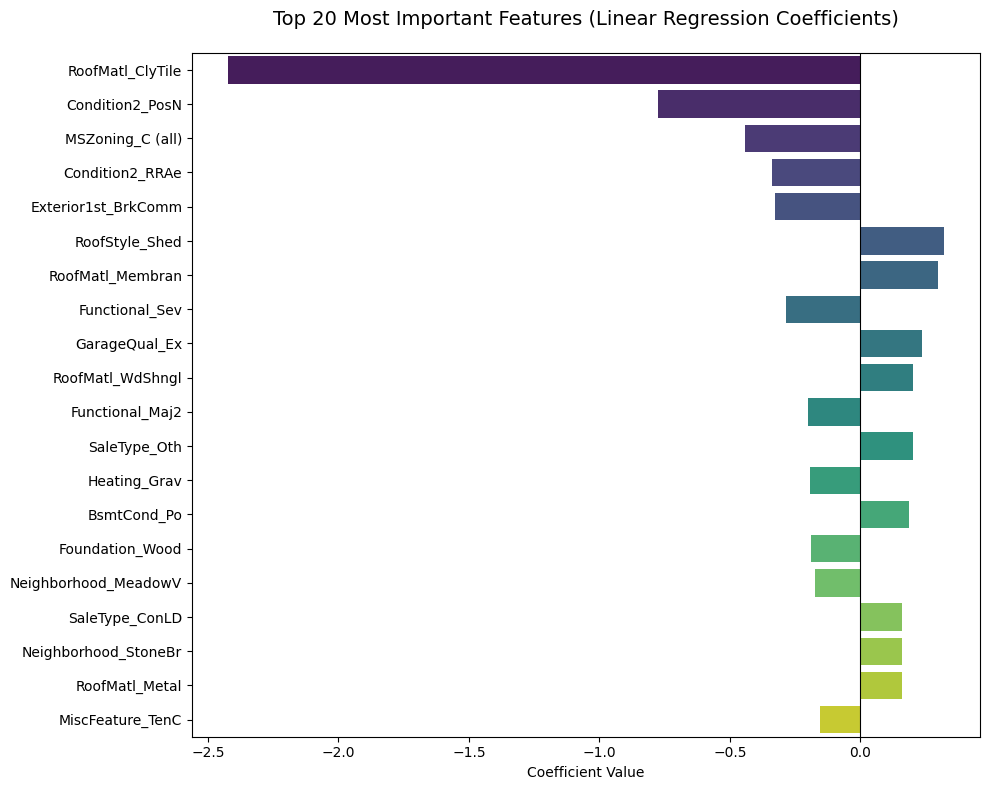

正向影响最大的 10 个特征：


,feature,coefficient,abs_coef
98,RoofStyle_Shed,0.321733,0.321733
105,RoofMatl_Membran,0.298231,0.298231
259,GarageQual_Ex,0.236036,0.236036
103,RoofMatl_WdShngl,0.202479,0.202479
296,SaleType_Oth,0.201676,0.201676
175,BsmtCond_Po,0.188359,0.188359
291,SaleType_ConLD,0.160323,0.160323
53,Neighborhood_StoneBr,0.159433,0.159433
106,RoofMatl_Metal,0.158536,0.158536
137,Exterior2nd_AsphShn,0.151434,0.151434



负向影响最大的 10 个特征：


,feature,coefficient,abs_coef
104,RoofMatl_ClyTile,-2.424256,2.424256
75,Condition2_PosN,-0.774443,0.774443
4,MSZoning_C (all),-0.442375,0.442375
76,Condition2_RRAe,-0.338445,0.338445
120,Exterior1st_BrkComm,-0.327914,0.327914
232,Functional_Sev,-0.286259,0.286259
231,Functional_Maj2,-0.201901,0.201901
201,Heating_Grav,-0.190955,0.190955
163,Foundation_Wood,-0.188230,0.188230
57,Neighborhood_MeadowV,-0.173340,0.173340


In [17]:
# ============== 6 线性回归系数 Top 20（完美修复版）==============
from pyspark.ml.regression import LinearRegressionModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 取出训练好的 LinearRegressionModel（最后一个 stage）
lr_model = model_lr.stages[-1]
assert isinstance(lr_model, LinearRegressionModel)
coefficients = lr_model.coefficients.toArray()

# 2. 重新构建完整的特征名列表（只从 Pipeline 的 transformer 阶段拿）
feature_names = []

# 只遍历除最后一个 LinearRegressionModel 之外的所有 stage
transformer_stages = model_lr.stages[:-1]

for stage in transformer_stages:
    # StringIndexer 的输出列是 xxx_idx
    if hasattr(stage, "getOutputCol") and stage.getOutputCol().endswith("_idx"):
        col_name = stage.getOutputCol()[:-4]  # 去掉 _idx 后缀
        # 获取该列所有类别（包括训练时见过的）
        labels = stage.labels
        # 因为 StringIndexer(handleInvalid="keep")，OneHot 会多一个未知类
        labels = list(labels) + ["OOV"]
        feature_names.extend([f"{col_name}_{label}" for label in labels])
    
    # 数值特征（StandardScaler 之后）
    elif hasattr(stage, "getOutputCol") and stage.getOutputCol() == "scaled_num":
        feature_names.extend(num_cols)

# 3. 构造系数 DataFrame 并绘图
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).assign(abs_coef=lambda x: x.coefficient.abs())

# Top 20 绝对值最大的系数
top20 = coef_df.reindex(coef_df.abs_coef.sort_values(ascending=False).index).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=top20, x="coefficient", y="feature", palette="viridis")
plt.title("Top 20 Most Important Features (Linear Regression Coefficients)", fontsize=14, pad=20)
plt.xlabel("Coefficient Value")
plt.ylabel("")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

# 额外打印正负影响最大的特征
print("正向影响最大的 10 个特征：")
display(coef_df.sort_values("coefficient", ascending=False).head(10))

print("\n负向影响最大的 10 个特征：")
display(coef_df.sort_values("coefficient", ascending=True).head(10))

In [8]:
from datetime import datetime
from pathlib import Path
import pyspark.sql.functions as F

# === 预测并转为 Pandas ===
submission_df = (model_lr.transform(test_df)
                 .withColumn("SalePrice", F.exp(F.col("prediction")) - 1)
                 .select("Id", "SalePrice")
                 .toPandas())

# === 直接保存为 CSV（无需 Spark 写文件）===
RESULT_DIR = Path.cwd().parent / "results" / datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
RESULT_DIR.mkdir(parents=True, exist_ok=True)

submission_df.to_csv(RESULT_DIR / "submission.csv", index=False)

In [9]:
spark.stop()